# Adversarial Examples

## If neural network models are as good as people say they are, why are they so easily fooled?

Research in AI and Machine Learning has a rich history of aiming to classify images. It makes sense, a computer classifying images well is both commercially useful and interesting to read about / see in action. From automatically tagging holiday photos for Instagram to setting up the foundations of a true surveilance state, there are many faucets from which can extract some worth from this field.

Within the last decade, you have likely heard someone say, or seen someone write something along the lines of "*Computers are better than humans at recognsing images*". A bold claim, but with [pocket sized technology accessible to consumers, that can identify the contents of images](https://www.theverge.com/2018/12/19/18149120/google-lens-ai-camera-recognize-detect-1-billion-items) it is easy to say where this comes from.

The graph below supports this idea, showing how in 2015 the first model was published that could defeat human classifcation in the ImageNet Image Classification Challenge.

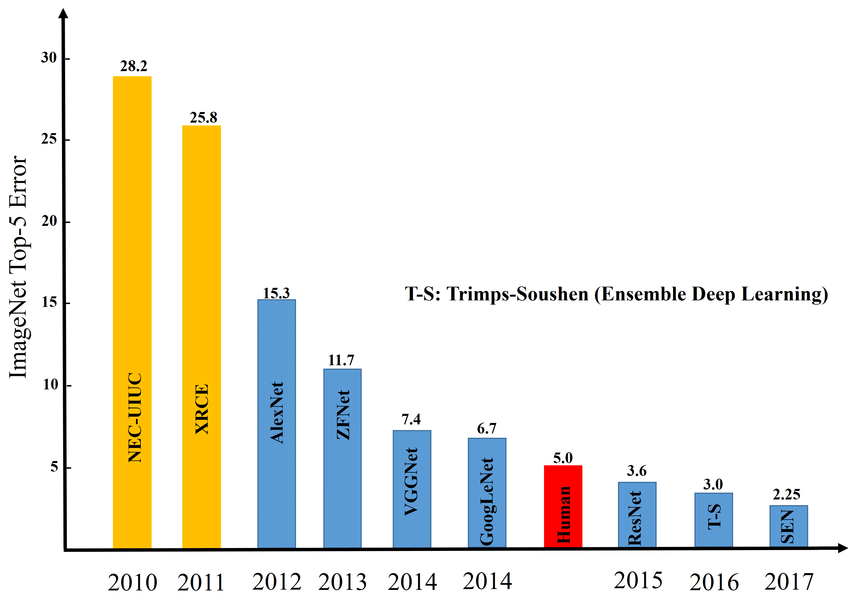
(note: Top-5 error refers to how often the correct answer was not within the top 5 guesses of each image classifier)

Impressive. I would forgive you for viewing this graph and thinking that 2015 was the year that shaped it all, that humanity should resign itself to its future status as second best to computers (at least in their ability to identify the subject of each arbitrary photo presented to them).

In 2015, one impressive model that came about and broke the "Human Level Classification" milestone, was Google's very own Inception-V3 classifier, with an impressive Top-5 Error of 3.7 (as outlined in [Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J. and Wojna, Z., 2016. Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).](https://arxiv.org/pdf/1512.03385.pdf)


However, if the Inception-V3 classifier is so imrpessive, why does this happen:

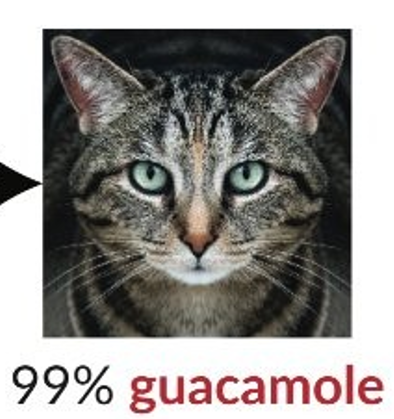

This is destressing result. When presented with what is (hopefully) obviously a picture of a cat, the Inception classifier is convinced that this image is in fact of guacamole. No human you would consider intelligent would come to this conclusion? surely?

I will dive into the origin of this result later, but in the meantime lets go back to basics and talk about how we train neural networks.

## In broad strokes, what goals might one set out when training an image classifier? How might they achieve them?

It does seem sensible that when training an image classifier, the goal set out is to reduce the error of the model against the training dataset. If one is doing this with a neural network, we have the ever handy tool of backpropagation to achieve this - and use gradient descent to <b>minimise</b> the error of the model.